In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from pytorch_msssim import ssim

import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
marmousi = 'SYNTHETIC_time.segy'

with segyio.open(marmousi, "r", ignore_geometry=True) as ss:
    n_traces = ss.tracecount
    sample_rate = segyio.tools.dt(ss) / 1000
    n_samples =ss.samples.size
    twt = ss.samples
    data = ss.trace.raw[:].T 

<function matplotlib.pyplot.show(close=None, block=None)>

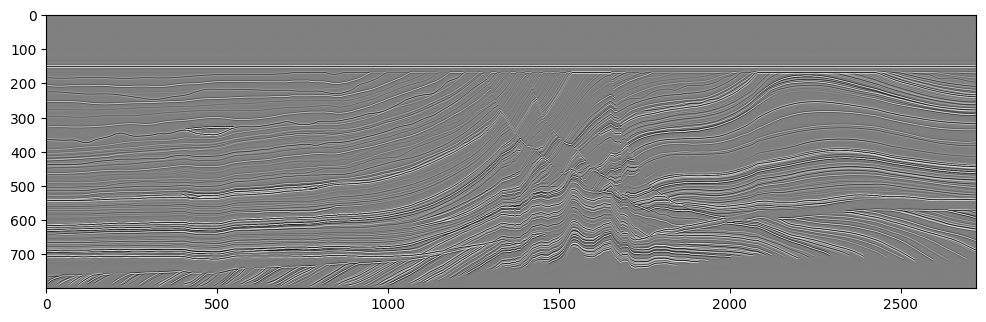

In [3]:
plt.figure(figsize=(12,6))
plt.imshow(data[:800], cmap='gray', vmin=-0.1, vmax=0.1)
plt.show

In [4]:
full_clean_img = np.expand_dims(np.expand_dims(data, axis=0), axis=0)
full_clean_img.shape

(1, 1, 1001, 2721)

In [5]:
# Data augmentation
class PolarityReversal:
    def __call__(self, image):
        return -image
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(size=(128,128)),
    PolarityReversal(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(degrees=(0,360), interpolation=transforms.InterpolationMode.BILINEAR)
])

dataset = []
noisy_dataset = []

def cropping(img, num_samples):
    _, _, h, w = img.shape
    if h&w > 128:
        for _ in range(num_samples):
            cropping = transform(img[0][0])
            dataset.append(cropping)
    else:
        print("Size doesn't match")

def noising_image(img, mean, std):
    noise = np.random.normal(loc=mean, scale=std, size=img.shape)
    noisy_img = np.add(img, noise)
    return noisy_img

def noising_dataset(dataset, mean, std):
    for i in range(len(dataset)):
        corrupted_img = noising_image(dataset[i], mean=mean, std=std)
        noisy_dataset.append(corrupted_img)

cropping(full_clean_img, num_samples=10000)
noising_dataset(dataset, 0, 0.1)

In [6]:
len(noisy_dataset)

10000

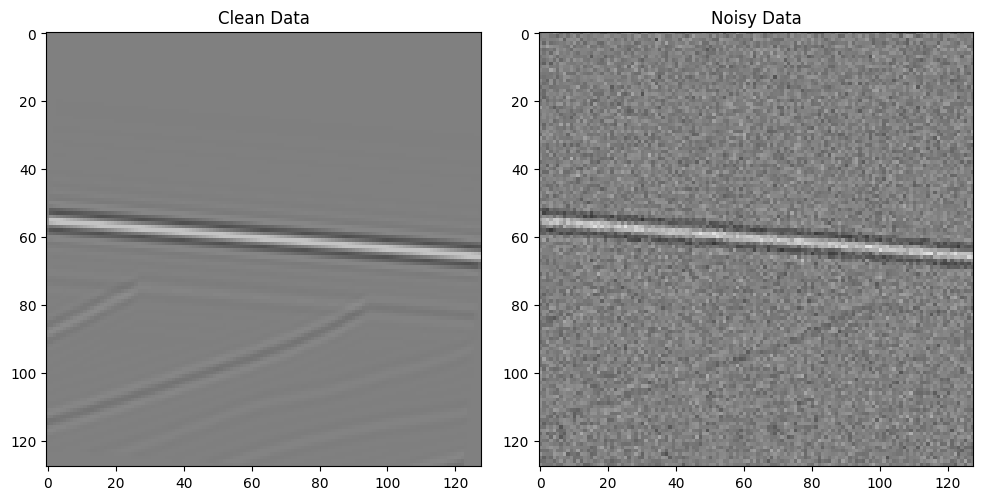

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
fig.tight_layout()
ax[0].set_title('Clean Data')
ax[0].imshow(dataset[1000][0], cmap='gray', vmin=-1, vmax=1)

ax[1].set_title('Noisy Data')
ax[1].imshow(noisy_dataset[1000][0], cmap='gray', vmin=-1, vmax=1)

plt.show()

In [8]:
dataset[0][0].shape

torch.Size([128, 128])

In [9]:
#Split dataset into train and validation set
class Dataset():
    def __init__(self, inputs, labels, transform=False):
        self.inputs = inputs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        labels = self.labels[idx]
        if self.transform:
            inputs = self.transform(inputs)
        
        return inputs, labels

train_labels=dataset[:int(0.8*len(dataset))]
val_labels=dataset[int(0.8*len(dataset)):]
train_inputs = noisy_dataset[:int(0.8*len(dataset))]
val_inputs = noisy_dataset[int(0.8*len(dataset)):]
    
train_dataset = Dataset(inputs=train_inputs, labels=train_labels)
val_dataset = Dataset(inputs=val_inputs, labels=val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
#Create UNet model
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.Conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.BN1 = nn.BatchNorm2d(out_channel)
        self.Conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.BN2 = nn.BatchNorm2d(out_channel)
        
    def forward(self, x):
        x = self.Conv1(x)
        x = self.BN1(x)
        x = self.Conv2(x)
        x = self.BN2(x)
        return x
    
class DownsamplingBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DownsamplingBlock, self).__init__()
        self.Pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ConvBlock = ConvBlock(in_channel, out_channel)
    
    def forward(self, x):
        x = self.Pooling(x)
        x = self.ConvBlock(x)
        return x
    
class Bottleneck(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Bottleneck, self).__init__()
        self.Downsampling = DownsamplingBlock(in_channel, out_channel)
        self.ConvBlock = ConvBlock(out_channel,  out_channel)

    def forward(self,x):
        x = self.Downsampling(x)
        x = self.ConvBlock(x)
        return x

class UpsamplingBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpsamplingBlock, self).__init__()
        self.Upsampling = nn.ConvTranspose2d(in_channel, in_channel, kernel_size=2, stride=2)
        self.ConvBlock = ConvBlock(in_channel + out_channel, out_channel)
    
    def forward(self, x1, x2):
        x1 = self.Upsampling(x1)
        hdiff = x2.size(2) - x1.size(2)
        wdiff = x2.size(3) - x1.size(3)
        x1 = nn.functional.pad(x1, [wdiff // 2, wdiff - wdiff // 2, hdiff // 2, hdiff - hdiff // 2])
        x = torch.cat([x1, x2], dim=1) 
        x = self.ConvBlock(x)
        return x
    
class SubPixelBlock(nn.Module):
    def __init__(self, in_channel, out_channel, upscale_factor=2):
        super(SubPixelBlock, self).__init__()
        self.Conv = nn.Conv2d(in_channel, out_channel*(upscale_factor**2), kernel_size=3, stride=1)
        self.PS = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.Conv(x)
        x = self.PS(x)
        return x

class UNet(nn.Module):
    def __init__(self,in_channel, out_channel):
        super(UNet, self).__init__()
        self.InputLayer = nn.Conv2d(in_channel, 32, kernel_size=3, stride=1, padding=1)
        self.Encoder1 = ConvBlock(32, 32)
        self.Encoder2 = DownsamplingBlock(32, 64)
        self.Encoder3 = DownsamplingBlock(64, 128)
        self.Encoder4 = DownsamplingBlock(128, 256)

        self.Bottleneck = Bottleneck(256, 512)

        self.Decoder1 = UpsamplingBlock(512, 256)
        self.Decoder2 = UpsamplingBlock(256, 128)
        self.Decoder3 = UpsamplingBlock(128, 64)
        self.Decoder4 = UpsamplingBlock(64, 32)
        
        self.final1 = ConvBlock(32, 32)
        self.final2 = ConvBlock(32, 32)
        self.final = nn.Conv2d(32, out_channel, kernel_size=1)

    def forward(self, x):
        Input = self.InputLayer(x)
        enc1 = self.Encoder1(Input)
        enc2 = self.Encoder2(enc1)
        enc3 = self.Encoder3(enc2)
        enc4 = self.Encoder4(enc3)

        bottleneck = self.Bottleneck(enc4)

        dec1 = self.Decoder1(bottleneck, enc4)
        dec2 = self.Decoder2(dec1, enc3)
        dec3 = self.Decoder3(dec2, enc2)
        dec4 = self.Decoder4(dec3, enc1)

        fin1 = self.final1(dec4)
        fin2 = self.final2(fin1)
        Output = self.final(fin2)
        return Output

In [11]:
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    pixel_max = 1.0
    psnr = 20 * torch.log10(pixel_max / torch.sqrt(mse))
    return psnr

#Create MSE-SSIM loss
class MSE_SSIM_Loss(nn.Module):
    def __init__(self, alpha=0.5):
        super(MSE_SSIM_Loss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        mse_loss = self.mse_loss(pred, target)
        ssim_loss = 1 - ssim(pred, target, data_range=1.0, size_average=True)

        #Combine loss
        total_loss = self.alpha * mse_loss + (1 - self.alpha) * ssim_loss
        return total_loss

In [12]:
# Initialize lists to store loss and PSNR
train_loss_hist = []
val_loss_hist = []
psnr_hist = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train model
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.float().to(device), labels.float().to(device)
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(inputs)
        labels = torch.nn.functional.interpolate(labels, size=outputs.shape[2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, labels)
        
        # Backward propagation
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(data_loader)
    train_loss_hist.append(train_loss)  # Save train loss for this epoch
    return train_loss, train_loss_hist, inputs, labels, outputs
    

# Evaluate model
def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss = 0.0
    total_psnr = 0.0
    psnr_values = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)

            # Forward propagation
            outputs = model(inputs)
            labels = torch.nn.functional.interpolate(labels, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, labels)

            # Calculate validation loss and PSNR
            val_loss += loss.item()

            # Compute PSNR for this batch and store it
            psnr_batch = calculate_psnr(outputs, labels)
            psnr_values.append(psnr_batch)

    val_loss /= len(data_loader)   
    avg_psnr = sum(psnr_values) / len(psnr_values)  # Compute average PSNR

    val_loss_hist.append(val_loss)
    psnr_hist.append(avg_psnr)

    return val_loss, avg_psnr, val_loss_hist, psnr_hist, inputs, labels, outputs

in_channel = 1
out_channel = 1
learning_rate = 0.001
epochs = 100

model = UNet(in_channel, out_channel).to(device)
criterion = MSE_SSIM_Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

for i in range(epochs):
    train_loss, train_loss_hist, train_inputs, train_labels, train_outputs = train(
        model=model, criterion=criterion, optimizer=optimizer, data_loader=train_loader
    )
    
    val_loss, avg_psnr, val_loss_hist, psnr_hist, val_inputs, val_labels, val_outputs = evaluate(
        model=model, criterion=criterion, data_loader=val_loader
    )

    print(f'Epoch {i+1}/{epochs}, Training loss: {train_loss:.5f}, Validation loss: {val_loss:.5f}, PSNR: {avg_psnr:.2f} dB')

Epoch 1/100, Training loss: 0.23960, Validation loss: 0.18564, PSNR: 24.45 dB
Epoch 2/100, Training loss: 0.17729, Validation loss: 0.18233, PSNR: 24.77 dB
Epoch 3/100, Training loss: 0.17669, Validation loss: 0.18297, PSNR: 24.55 dB
Epoch 4/100, Training loss: 0.17741, Validation loss: 0.18053, PSNR: 24.84 dB
Epoch 5/100, Training loss: 0.17421, Validation loss: 0.17933, PSNR: 24.88 dB
Epoch 6/100, Training loss: 0.17293, Validation loss: 0.17799, PSNR: 24.77 dB
Epoch 7/100, Training loss: 0.17053, Validation loss: 0.16774, PSNR: 25.88 dB
Epoch 8/100, Training loss: 0.15965, Validation loss: 0.15356, PSNR: 26.99 dB
Epoch 9/100, Training loss: 0.14625, Validation loss: 0.14047, PSNR: 28.71 dB
Epoch 10/100, Training loss: 0.13461, Validation loss: 0.13276, PSNR: 30.44 dB
Epoch 11/100, Training loss: 0.12883, Validation loss: 0.12935, PSNR: 30.02 dB
Epoch 12/100, Training loss: 0.12576, Validation loss: 0.12754, PSNR: 30.08 dB
Epoch 13/100, Training loss: 0.12376, Validation loss: 0.1259

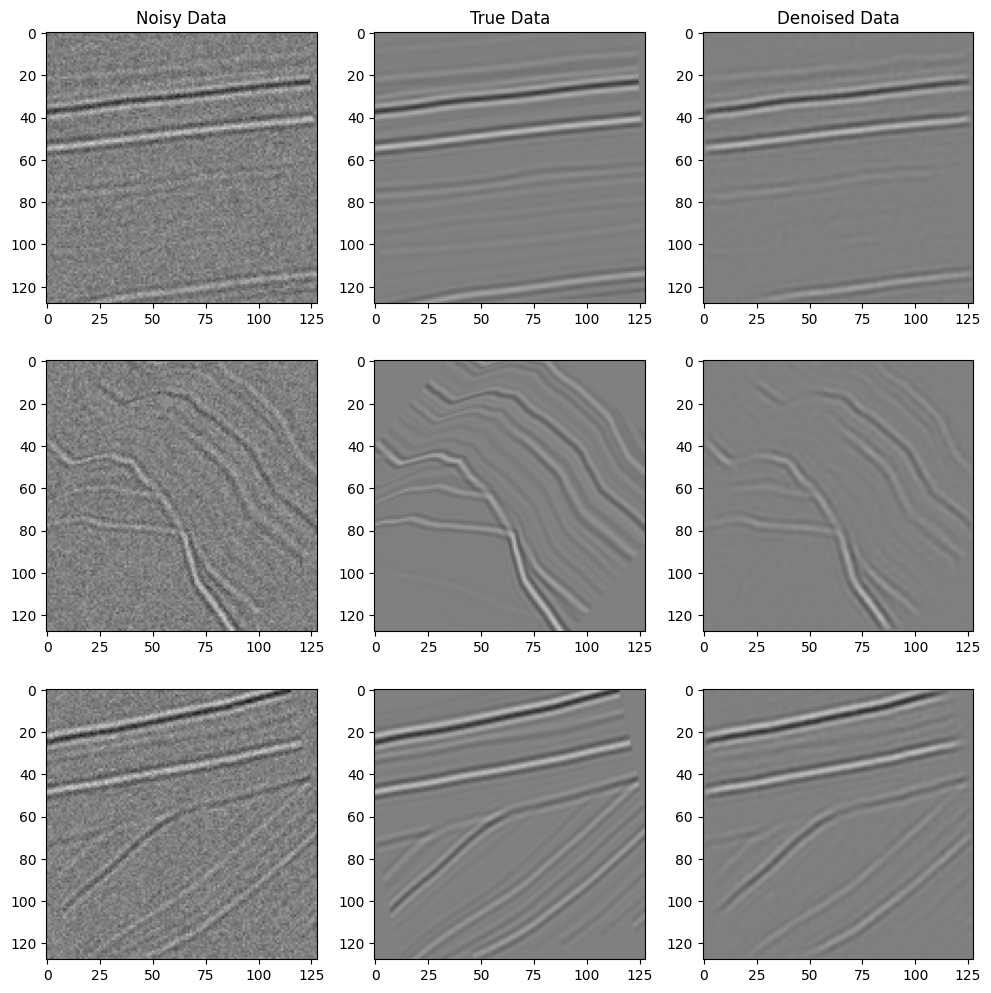

In [29]:
sample1 = 15
sample2 = 0
sample3 = 11

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
fig.tight_layout()
ax[0,0].set_title('Noisy Data')
ax[0,0].imshow(val_inputs[sample1][0].cpu(), cmap='gray', vmin=-1, vmax=1)
ax[1,0].imshow(val_inputs[sample2][0].cpu(), cmap='gray', vmin=-1, vmax=1)
ax[2,0].imshow(val_inputs[sample3][0].cpu(), cmap='gray', vmin=-1, vmax=1)

ax[0,1].set_title('True Data')
ax[0,1].imshow(val_labels[sample1][0].cpu(), cmap='gray', vmin=-1, vmax=1)
ax[1,1].imshow(val_labels[sample2][0].cpu(), cmap='gray', vmin=-1, vmax=1)
ax[2,1].imshow(val_labels[sample3][0].cpu(), cmap='gray', vmin=-1, vmax=1)

ax[0,2].set_title('Denoised Data')
ax[0,2].imshow(val_outputs[sample1][0].cpu(), cmap='gray', vmin=-1, vmax=1)
ax[1,2].imshow(val_outputs[sample2][0].cpu(), cmap='gray', vmin=-1, vmax=1)
ax[2,2].imshow(val_outputs[sample3][0].cpu(), cmap='gray', vmin=-1, vmax=1)
plt.show()

In [15]:
#Extract PSNR values
psnr_hist = [psnr.cpu().item() for psnr in psnr_hist]

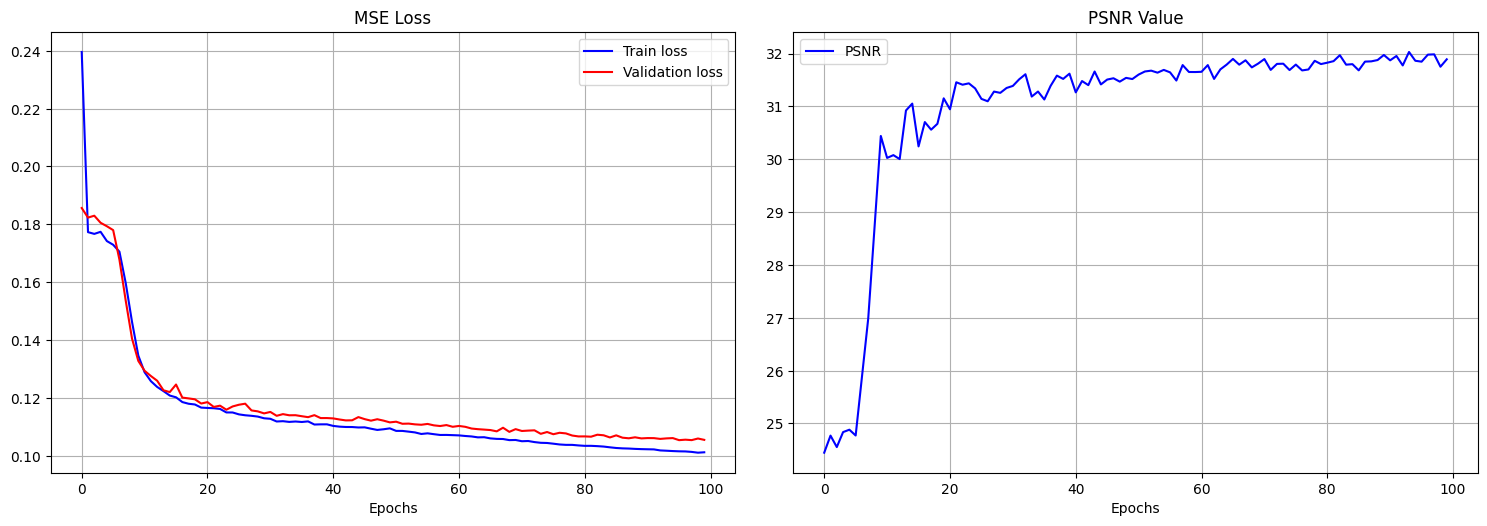

In [30]:
#Extract PSNR values
#psnr_hist = [psnr.cpu().item() for psnr in psnr_hist]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.tight_layout()
ax[0].set_title('MSE Loss')
ax[0].grid()
ax[0].plot(train_loss_hist, c='blue', label='Train loss')
ax[0].plot(val_loss_hist, c='red', label='Validation loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].set_title('PSNR Value')
ax[1].grid()
ax[1].plot(psnr_hist, c='blue', label='PSNR')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.show()

In [31]:
torch.save(model.state_dict(), "denoising_model_new.pth")
print("Model saved successfully.")

Model saved successfully.


In [ ]:
val_inputs.shape

In [ ]:
val_outputs.shape

In [ ]:
val_labels.shape

In [ ]:
psnr_hist[0].cpu()